# **Product Recognition of Food Products**

## Image Processing and Computer Vision - Assignment Module \#1


Contacts:

- Prof. Giuseppe Lisanti -> giuseppe.lisanti@unibo.it
- Prof. Samuele Salti -> samuele.salti@unibo.it
- Alex Costanzino -> alex.costanzino@unibo.it
- Francesco Ballerini -> francesco.ballerini4@unibo.it


Computer vision-based object detection techniques can be applied in super market settings to build a system that can identify products on store shelves.
An example of how this system could be used would be to assist visually impaired customers or automate common store management tasks like detecting low-stock or misplaced products, given an image of a shelf in a store.

## Task
Develop a computer vision system that, given a reference image for each product, is able to identify such product from one picture of a store shelf.

<figure>
<a href="https://imgbb.com/">
  <center>
  <img src="https://i.ibb.co/TwkMWnH/Screenshot-2024-04-04-at-14-54-51.png" alt="Screenshot-2024-04-04-at-14-54-51" border="0" width="300" />
</a>
</figure>

For each type of product displayed in the
shelf the system should report:
1. Number of instances;
1. Dimension of each instance (width and height in pixel of the bounding box that enclose them);
1. Position in the image reference system of each instance (center of the bounding box that enclose them).

#### Example of expected output
```
Product 0 - 2 instance found:
  Instance 1 {position: (256, 328), width: 57px, height: 80px}
  Instance 2 {position: (311, 328), width: 57px, height: 80px}
Product 1 – 1 instance found:
.
.
.
```

### Track A - Single Instance Detection
Develop an object detection system to identify single instance of products given one reference image for each item and a scene image.

The system should be able to correctly identify all the product in the shelves
image.

### Track B - Multiple Instances Detection
In addition to what achieved at step A, the system should also be able to detect multiple instances of the same product.

## Data
Two folders of images are provided:
* **Models**: contains one reference image for each product that the system should be able to identify.
* **Scenes**: contains different shelve pictures to test the developed algorithm in different scenarios. The images contained in this folder are corrupted by noise.

#### Track A - Single Instance Detection
* **Models**: {ref1.png to ref14.png}.
* **Scenes**: {scene1.png to scene5.png}.

#### Track B - Multiple Instances Detection
* **Models**: {ref15.png to ref27.png}.
* **Scenes**: {scene6.png to scene12.png}.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# !cp -r /content/drive/MyDrive/AssignmentsIPCV/dataset.zip ./
# !unzip dataset.zip

## Evaluation criteria
1. **Procedural correctness**. There are several ways to solve the assignment. Design your own sound approach and justify every decision you make;

2. **Clarity and conciseness**. Present your work in a readable way: format your code and comment every important step;

3. **Correctness of results**. Try to solve as many instances as possible. You should be able to solve all the instances of the assignment, however, a thoroughly justified and sound procedure with a lower number of solved instances will be valued **more** than a poorly designed approach.

# START OF OUR CODE

### Imports

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

### Begin by denoising the provided scenes to help the product identifying algorithm

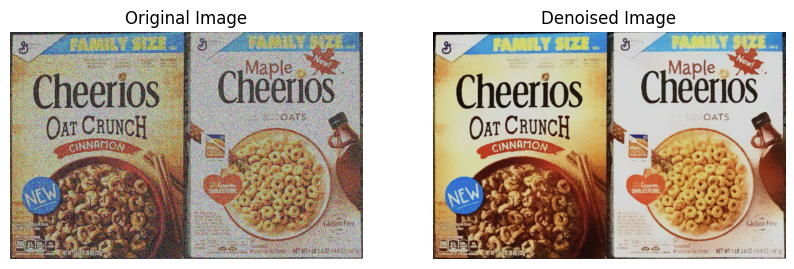

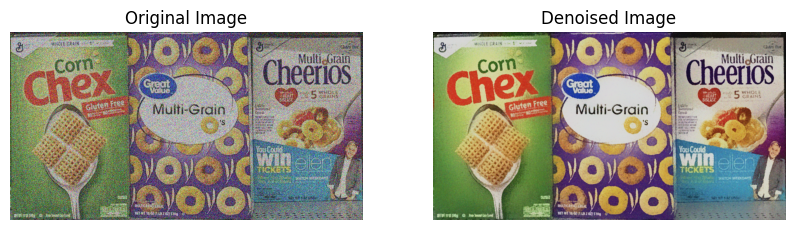

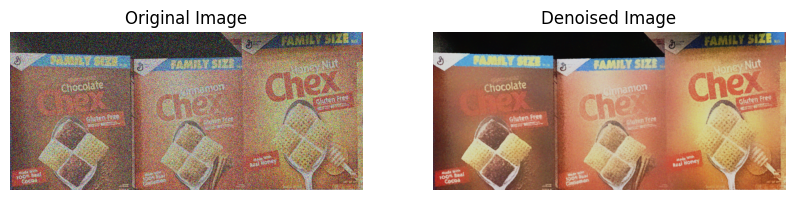

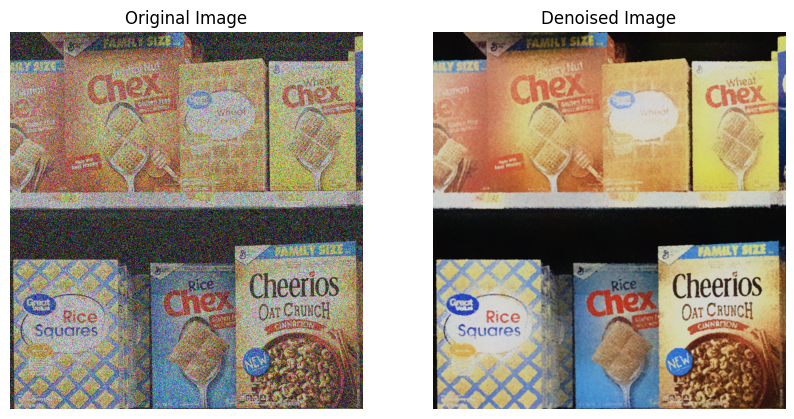

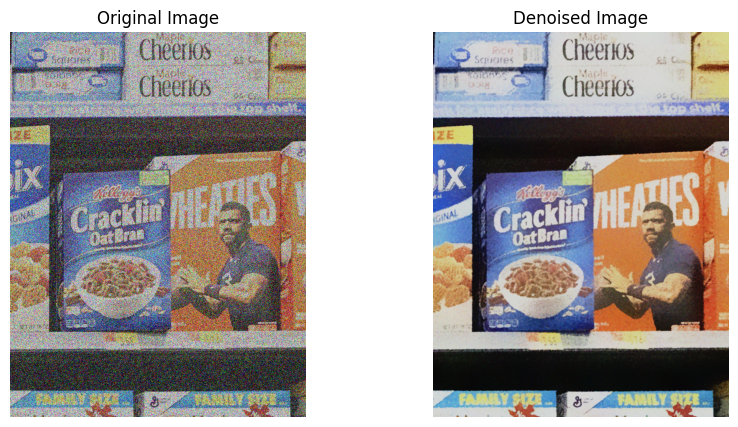

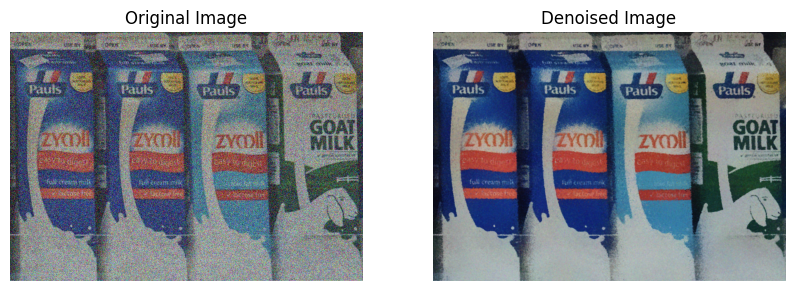

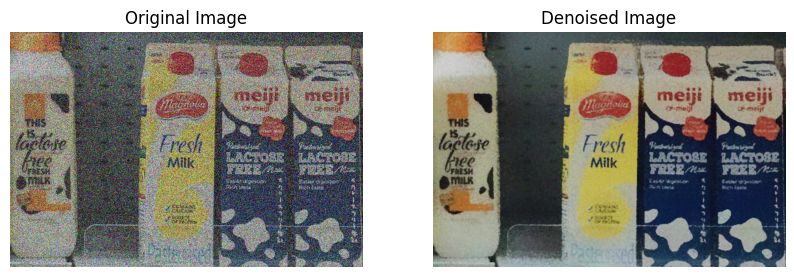

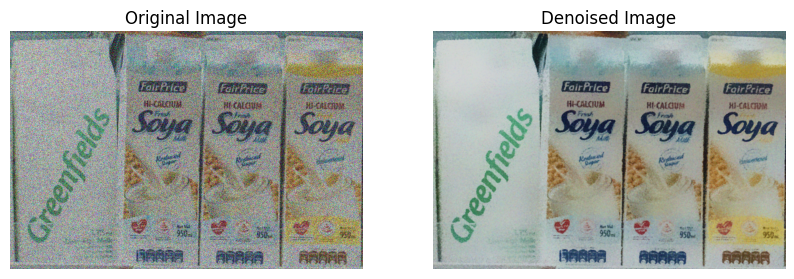

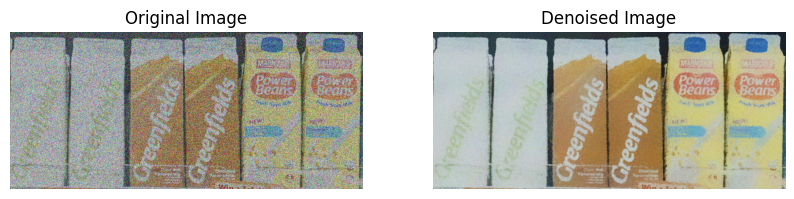

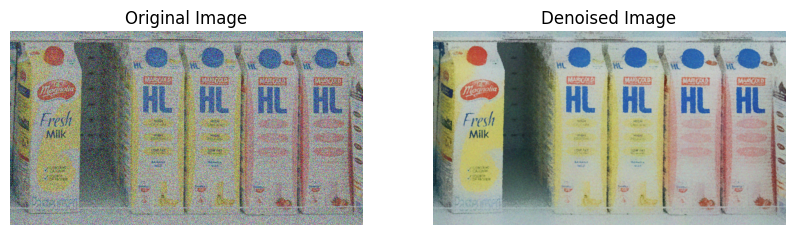

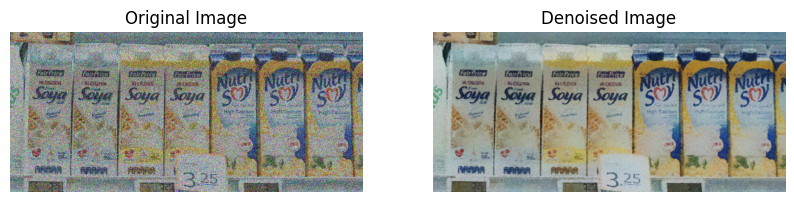

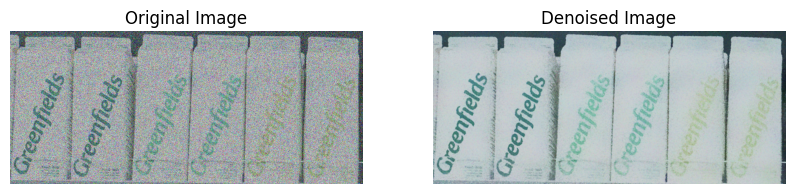

In [2]:
def DeNoise(dir, newdir, num):
    '''
    A preprocessing function to repair the noisy scenes!

    Arguments:
    - dir: str, the original directory containing the noisy images.
    - newdir: str, the directory where denoised images will be saved.
    - num: int, the number of images to process.
    '''
    # Create the new directory
    if not os.path.exists(newdir):
        os.mkdir(newdir)

    # Iterate through the image names
    img_names = [f"scene{i}.png" for i in range(1,num+1)]
    for img_name in img_names:
        # Read the image
        img = cv2.imread(dir+img_name)
        # Convert image to RGB
        rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Remove impulse noise using a median filter
        removed_impulse_img = cv2.medianBlur(rgb_img, 5)
        # Remove Gaussian noise without smoothing using a bilater filter
        filtered_img = cv2.bilateralFilter(removed_impulse_img, d=100, sigmaColor=75, sigmaSpace=75)
        # Convert image to BGR to write it
        filtered_img_bgr = cv2.cvtColor(filtered_img, cv2.COLOR_RGB2BGR) 
        cv2.imwrite(newdir+img_name, filtered_img_bgr)

        # Plotting
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        # Plot the original noisy image
        axes[0].imshow(rgb_img)
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        # Plot the filtered denoised image
        axes[1].imshow(filtered_img)
        axes[1].set_title('Denoised Image')
        axes[1].axis('off')

        plt.show()

DeNoise(dir='dataset/scenes/', newdir='dataset/denoised_scenes/', num=12)

## Keypoints Detection

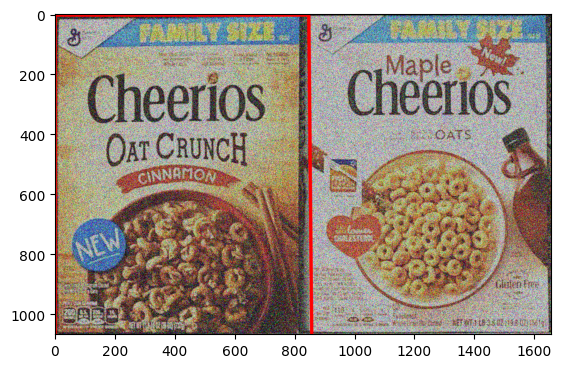

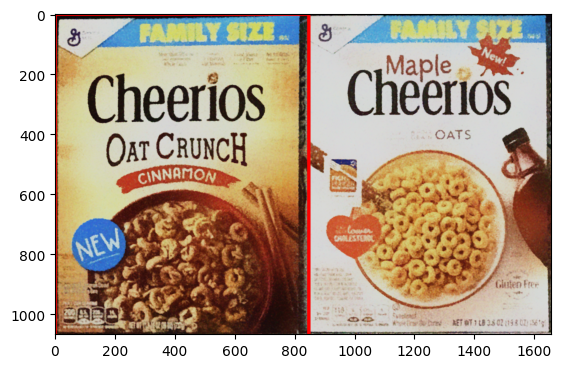

In [24]:
# Initiate SIFT detector
noisy_scene1 = cv2.imread('dataset/scenes/scene1.png')
denoised_scene1 = cv2.imread('dataset/denoised_scenes/scene1.png')
model1 = cv2.imread('dataset/models/ref1.png')

# Change from BGR to RGB
noisy_scene1 = cv2.cvtColor(noisy_scene1, cv2.COLOR_BGR2RGB)
denoised_scene1 = cv2.cvtColor(denoised_scene1, cv2.COLOR_BGR2RGB)
model1 = cv2.cvtColor(model1, cv2.COLOR_BGR2RGB)

# Create Detector and detect keypoints
sift = cv2.SIFT_create()
noisy_kp_scene1 = sift.detect(noisy_scene1)
denoised_kp_scene1 = sift.detect(denoised_scene1)
kp_model1 = sift.detect(denoised_scene1)

# Draw Keypoints and print
#img_visualization = cv2.drawKeypoints(noisy_scene1, noisy_kp_scene1, None, flags=4)
#plt.imshow(img_visualization)
#plt.show()

# Compute descriptors on scene images
noisy_kp_scene1, noisy_des_scene1 = sift.compute(noisy_scene1, noisy_kp_scene1)
denoised_kp_scene1, denoised_des_scene1 = sift.compute(denoised_scene1, denoised_kp_scene1)

# Compute descriptors on model image
kp_model1, des_model1 = sift.compute(model1, kp_model1)


# Set up for kdtree
FLANN_INDEX_KDTREE = 1

index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

# Matching keypoints for both noisy image and the denoised one 
noisy_matches = flann.knnMatch(des_model1, noisy_des_scene1, k=2)
denoised_matches = flann.knnMatch(des_model1, denoised_des_scene1,k=2)

# Discarding ambiguous matches
noisy_good = []
denoised_good = []

for m,n in noisy_matches:
    if m.distance < 0.7*n.distance:
        noisy_good.append(m)
        
for m,n in denoised_matches:
    if m.distance < 0.7*n.distance:
        denoised_good.append(m)
        
# Checking if we found enough matching
MIN_MATCH_COUNT = 10

# Noisy case
if len(noisy_good)>MIN_MATCH_COUNT:
    # building the corrspondences arrays of good matches
    src_pts = np.float32([ kp_model1[m.queryIdx].pt for m in noisy_good ]).reshape(-1,1,2)
    dst_pts = np.float32([ noisy_kp_scene1[m.trainIdx].pt for m in noisy_good ]).reshape(-1,1,2)
    
    # Using RANSAC to estimate a robust homography.
    # It returns the homography M and a mask for the discarded points
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # Mask of discarded point used in visualization
    matchesMask = mask.ravel().tolist()

    # Corners of the query image
    h,w, _ = model1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

    # Projecting the corners into the train image
    dst = cv2.perspectiveTransform(pts,M)

    # Drawing the bounding box
    img_train_p = cv2.polylines(noisy_scene1,[np.int32(dst)],True,255,10, cv2.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(noisy_good), MIN_MATCH_COUNT) )
    matchesMask = None
    
plt.imshow(img_train_p)
plt.show()

# Denosied case
if len(denoised_good)>MIN_MATCH_COUNT:
    # building the corrspondences arrays of good matches
    src_pts = np.float32([ kp_model1[m.queryIdx].pt for m in denoised_good ]).reshape(-1,1,2)
    dst_pts = np.float32([ denoised_kp_scene1[m.trainIdx].pt for m in denoised_good ]).reshape(-1,1,2)
    
    # Using RANSAC to estimate a robust homography.
    # It returns the homography M and a mask for the discarded points
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # Mask of discarded point used in visualization
    matchesMask = mask.ravel().tolist()

    # Corners of the query image
    h,w, _ = model1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

    # Projecting the corners into the train image
    dst = cv2.perspectiveTransform(pts,M)

    # Drawing the bounding box
    img_train_p = cv2.polylines(denoised_scene1,[np.int32(dst)],True,255,10, cv2.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(noisy_good), MIN_MATCH_COUNT) )
    matchesMask = None
    
plt.imshow(img_train_p)
plt.show()

# THIS CODE BELOW TO BE DELETED BEFORE SUBMISSION

In [ ]:

# Load a reference image
img = cv2.imread("dataset/models/ref1.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Load a scene
scene = cv2.imread("dataset/scenes/scene1.png")
scene = cv2.cvtColor(scene, cv2.COLOR_BGR2RGB)

# Print
plt.imshow(img)
plt.axis('off')
plt.show()
plt.imshow(scene)
plt.axis('off')
plt.show()

filter_scene = scene.copy()

# Use a median filter to remove impulse noise
# Define the size of the impulse kernel (e.g., 3x3)
kernel_size = 10

# # Create an impulse kernel
# impulse_kernel = np.zeros((kernel_size, kernel_size), dtype=np.uint8)
# center = (kernel_size - 1) // 2
# impulse_kernel[center, center] = 1
# filter_scene = cv2.filter2D(filter_scene, -1, impulse_kernel)

# Create a median filter
filter_scene = cv2.medianBlur(filter_scene, 5)

# Follow by linear filtering to remove guassian noise

# A simple mean filter
k_size = 9
mean_kernel = np.ones([k_size, k_size])/(k_size**2)
# filter_scene = cv2.filter2D(filter_scene, -1, mean_kernel)

# An API Guassian filter
# filter_scene = cv2.GaussianBlur(filter_scene, (9, 9), 5)

# Bilaterial filter
filter_scene = cv2.bilateralFilter(filter_scene, d=100, sigmaColor=75, sigmaSpace=75)

# IDEA: THERE IS MORE NOISE IN SOME R, G, B CHANNELS THAN OTHERS?

plt.imshow(filter_scene)
plt.axis('off')
plt.show()

# Print the seperate R,G,B channels
R = scene[:,:,0] # Getting the first axis (R)
G = scene[:,:,1] # Getting the second axis (G)
B = scene[:,:,2] # Getting the third axis (B)

plt.figure(figsize = (20, 10))

plt.subplot(1,3,1)
plt.imshow(R, cmap = 'gray', vmin = 0, vmax = 255)
plt.title('RED CHANNEL')

plt.subplot(1,3,2)
plt.imshow(G, cmap = 'gray', vmin = 0, vmax = 255)
plt.title("GREEN CHANNEL")

plt.subplot(1,3,3)
plt.imshow(B, cmap = 'gray', vmin = 0, vmax = 255)
plt.title("BLUE CHANNEL")

plt.show()